# Generative Adversarial Networks

Paper: [Goodfellow, Ian, et al. "Generative adversarial nets." Advances in neural information processing systems. 2014.](https://papers.nips.cc/paper/5423-generative-adversarial-nets)

In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.autograd import Variable

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from torchvision import datasets, transforms

from tqdm import tqdm

%matplotlib inline

## Configuration and Hyperparameters

In [2]:
batch_size = 16
noise_size = 100
hidden_size = 128
learning_rate = 1e-3
plot_size = 10
epochs = 10

## Load the dataset

In [3]:
use_cuda = torch.cuda.is_available()

In [4]:
mnist = torch.utils.data.DataLoader(
    datasets.MNIST('data/mnist/raw/',
                   train=True,
                   download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

In [5]:
image_height = mnist.dataset.train_data.shape[1]
image_width = mnist.dataset.train_data.shape[2]
image_size = image_height * image_width
print("Number of features:", image_size)

Number of features: 784


## Models

In [6]:
def initialize_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0.0)

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(noise_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, image_size),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.layers(inputs)

In [8]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(image_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        return self.layers(inputs)

## Train the networks

In [9]:
generator = Generator()
discriminator = Discriminator()

generator.apply(initialize_weights)
discriminator.apply(initialize_weights)

optim_generator = optim.Adam(generator.parameters(), lr=learning_rate)
optim_discriminator = optim.Adam(discriminator.parameters(), lr=learning_rate)

ones_label = Variable(torch.ones(batch_size, 1))
zeros_label = Variable(torch.zeros(batch_size, 1))

In [10]:
def generate_noise(size):
    return torch.randn(size, noise_size)

In [11]:
def generate_images(size):
    with torch.no_grad():
        noise = Variable(generate_noise(size))
        if use_cuda:
            noise = noise.cuda()
        images = generator(noise)
    return images.data

In [12]:
def plot_images(images):
    fig = plt.figure(figsize=(len(images), 1))
    gs = gridspec.GridSpec(1, len(images))
    gs.update(wspace=0.05, hspace=0.05)
    
    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')

        plt.imshow(image.reshape(image_width, image_height),
                   cmap='Greys_r',
                   interpolation='None')
        
    plt.show()

In [13]:
if use_cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    
    ones_label = ones_label.cuda()
    zeros_label = zeros_label.cuda()

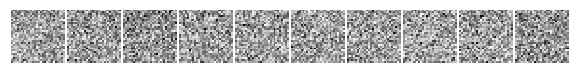

Epoch 1/10: 100%|██████████| 3750/3750 [04:08<00:00, 20.76it/s, discriminator=0.269, generator=3.298] 


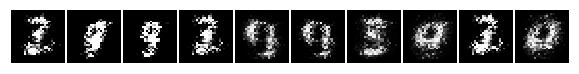

Epoch 2/10: 100%|██████████| 3750/3750 [04:48<00:00, 13.04it/s, discriminator=0.373, generator=3.166]


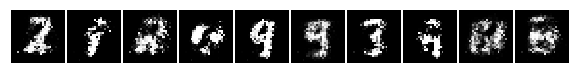

Epoch 3/10: 100%|██████████| 3750/3750 [05:01<00:00,  9.69it/s, discriminator=0.565, generator=3.349]


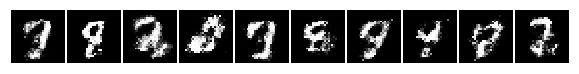

Epoch 4/10: 100%|██████████| 3750/3750 [05:15<00:00, 11.87it/s, discriminator=0.978, generator=2.288]


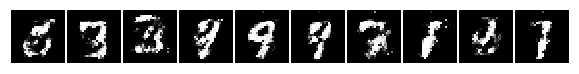

Epoch 5/10: 100%|██████████| 3750/3750 [05:19<00:00,  7.47it/s, discriminator=0.818, generator=1.766]


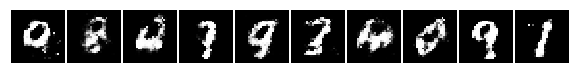

Epoch 6/10: 100%|██████████| 3750/3750 [05:07<00:00, 10.87it/s, discriminator=0.609, generator=1.844]


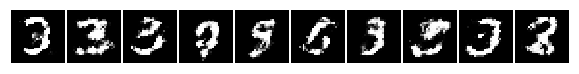

Epoch 7/10: 100%|██████████| 3750/3750 [05:19<00:00,  5.71it/s, discriminator=1.062, generator=1.602]


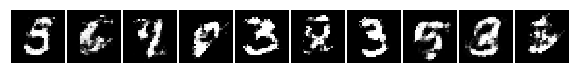

Epoch 8/10: 100%|██████████| 3750/3750 [05:14<00:00, 11.94it/s, discriminator=0.852, generator=1.420]


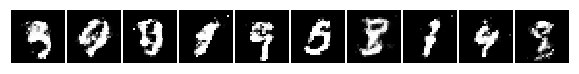

Epoch 9/10: 100%|██████████| 3750/3750 [02:28<00:00, 92.53it/s, discriminator=1.077, generator=1.849]


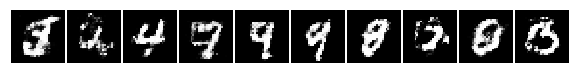

Epoch 10/10: 100%|██████████| 3750/3750 [00:45<00:00, 81.55it/s, discriminator=0.672, generator=1.484]


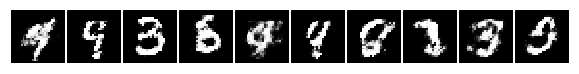

In [14]:
plot_images(generate_images(plot_size))

for epoch in range(epochs):
    with tqdm(total=len(mnist)) as progress_bar:
        progress_bar.set_description("Epoch {:d}/{:d}".format(epoch + 1, epochs))
        for iteration, (real_images, _) in enumerate(mnist):
            # train discriminator
            optim_discriminator.zero_grad()

            noise = Variable(generate_noise(batch_size))
            real_images = Variable(real_images).view(-1, image_size)
            if use_cuda:
                noise = noise.cuda()
                real_images = real_images.cuda()

            fake_images = generator(noise)
            real_pred = discriminator(real_images)
            fake_pred = discriminator(fake_images)

            loss_real = F.binary_cross_entropy(real_pred, ones_label)
            loss_fake = F.binary_cross_entropy(fake_pred, zeros_label)
            loss_discriminator = loss_real + loss_fake

            loss_discriminator.backward()
            optim_discriminator.step()

            # train generator
            optim_generator.zero_grad()

            noise = Variable(generate_noise(batch_size))
            if use_cuda:
                noise = noise.cuda()

            fake_images = generator(noise)
            fake_pred = discriminator(fake_images)

            loss_generator = F.binary_cross_entropy(fake_pred, ones_label)

            loss_generator.backward()
            optim_generator.step()
            
            # logging
            if use_cuda:
                loss_discriminator = loss_discriminator.cpu()
                loss_generator = loss_generator.cpu()
            
            progress_bar.set_postfix(
                discriminator="{:.03f}".format(loss_discriminator.data.item()),
                generator="{:.03f}".format(loss_generator.data.item()))
            
            progress_bar.update()
        
    plot_images(generate_images(plot_size))